<a href="https://colab.research.google.com/github/khairul746/IDCamp-ML-Engineer-2024-Projects/blob/main/Analisis-Sentimen/Sentiment_Analysis_on_MyTelkomsel_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Sentimen pada Aplikasi My Telkomsel

## 1. Import Library dan Import Data

In [1]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:00


In [2]:
import pandas as pd  # Pandas untuk manipulasi dan analisis data
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining
import numpy as np  # NumPy untuk komputasi numerik
seed = 0
np.random.seed(seed)  # Mengatur seed untuk reproduktibilitas
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
from sklearn.metrics import accuracy_score

import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
import unicodedata # Modul untuk bekerja dengan Unicode
import requests # Modul yang memungkinkan untuk mengirim htttp request
import os # Modul untuk pekerja terkait os seperti manajemen file

from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks

from Sastrawi.Stemmer import StemmerFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks

import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.
nltk.download('punkt_tab') # Download the punkt_tab data package
pd.options.mode.copy_on_write = True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.optimizers import RMSprop, AdamW, Adam
from sklearn.model_selection import train_test_split

In [4]:
app_reviews_df = pd.read_csv('app_reviews.csv')

## 2. Dataset Overview

In [5]:
app_reviews_df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,bb582a94-9844-40aa-8c97-506e07c22fb7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Jujur pake Shopee ini baguss banget sebenernya...,2,20,3.42.24,2025-01-21 20:19:08,"Hai kak, mohon maaf atas ketidaknyamanan nya. ...",2025-01-21 21:18:24,3.42.24
1,d8474dc1-da09-4605-9aab-de73f1d61dbe,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Terus terang saya suka sekali belanja di shope...,3,17,3.42.24,2025-01-21 05:13:42,NaN,NaN,3.42.24
2,63dbc9c4-2da7-4825-b335-2a5a1e1575de,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasinya bagus, mudah dipahami. Seeing bela...",5,309,3.42.24,2025-01-20 09:29:58,"Hi kak, maaf ya udh buat kamu ga nyaman. Terka...",2023-02-07 16:24:08,3.42.24


In [6]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              3000 non-null   object
 1   userName              3000 non-null   object
 2   userImage             3000 non-null   object
 3   content               3000 non-null   object
 4   score                 3000 non-null   int64 
 5   thumbsUpCount         3000 non-null   int64 
 6   reviewCreatedVersion  3000 non-null   object
 7   at                    3000 non-null   object
 8   replyContent          2808 non-null   object
 9   repliedAt             2808 non-null   object
 10  appVersion            3000 non-null   object
dtypes: int64(2), object(9)
memory usage: 257.9+ KB


In [7]:
df = app_reviews_df[['content','score']]

In [8]:
# Mengecek data yang kosong atau hilang
df.isnull().sum()

,0
content,0
score,0


In [9]:
# Menghapus baris yang memiliki duplikat
df.drop_duplicates(inplace=True)

## 3. Text Preprocessing

In [10]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def remove_superscripts_and_subscripts(text):
    # memfilter karakter yang bukan superscript atau subscript
    def is_not_super_or_sub(char):
        # Cek kategori Unicode karakter
        return not (unicodedata.name(char, "").startswith("SUPERSCRIPT") or
                    unicodedata.name(char, "").startswith("SUBSCRIPT"))

    # Filter karakter dari teks
    text = ''.join(filter(is_not_super_or_sub, text))
    return text

def casefoldingText(text):
    # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text):
    # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text):
    # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata

    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [11]:
# URL file slang words
url = "https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt"

# Mengambil konten file dari URL
response = requests.get(url)
if response.status_code == 200:
    content = response.text
    # Memproses konten ke dalam dictionary
    slangwords = {}
    for line in content.strip().split(","):
        if ":" in line:
            key, value = line.split(":", 1)  # Memisahkan kata slang dan arti
            key = key.strip('{"}') # Menghilangkan tanda kurung kurawal pada key
            value = value.strip('{"}') # Menghilangkan tanda kurung kurawal pada value
            slangwords[key.strip(' "\'')] = value.strip(' "\'') # Menyimpan pasangan key-value pada dictionary slangwords
else:
    print(f"Gagal mengunduh file dari URL. Status code: {response.status_code}")


In [12]:
list(slangwords.items())[:5]

[('@', 'di'),
 ('abis', 'habis'),
 ('ad', 'ada'),
 ('adlh', 'adalah'),
 ('afaik', 'as far as i know')]

In [13]:
def fix_slangwords(text):
    # Memperbaiki kata-kata slang dalam teks
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [14]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['content'].apply(cleaningText).apply(remove_superscripts_and_subscripts)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

In [15]:
df.head()

,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Jujur pake Shopee ini baguss banget sebenernya...,2,Jujur pake Shopee ini baguss banget sebenernya...,jujur pake shopee ini baguss banget sebenernya...,jujur pakai shopee ini baguss banget sebenerny...,"[jujur, pakai, shopee, ini, baguss, banget, se...","[jujur, pakai, shopee, baguss, banget, sebener...",jujur pakai shopee baguss banget sebenernya be...
1,Terus terang saya suka sekali belanja di shope...,3,Terus terang saya suka sekali belanja di shope...,terus terang saya suka sekali belanja di shope...,terus terang saya suka sekali belanja di shope...,"[terus, terang, saya, suka, sekali, belanja, d...","[terang, suka, belanja, shopee, kesini, shopee...",terang suka belanja shopee kesini shopee memba...
2,"Aplikasinya bagus, mudah dipahami. Seeing bela...",5,Aplikasinya bagus mudah dipahami Seeing belanj...,aplikasinya bagus mudah dipahami seeing belanj...,aplikasinya bagus mudah dipahami seeing belanj...,"[aplikasinya, bagus, mudah, dipahami, seeing, ...","[aplikasinya, bagus, mudah, dipahami, seeing, ...",aplikasinya bagus mudah dipahami seeing belanj...
3,1. Pesanan cod roksaya dibatalkan sendiri oleh...,3,Pesanan cod roksaya dibatalkan sendiri oleh si...,pesanan cod roksaya dibatalkan sendiri oleh si...,pesanan cod roksaya dibatalkan sendiri oleh si...,"[pesanan, cod, roksaya, dibatalkan, sendiri, o...","[pesanan, cod, roksaya, dibatalkan, sistem, me...",pesanan cod roksaya dibatalkan sistem melewati...
4,"Aplikasi elit benerin bug shopeepay sulit, tia...",2,Aplikasi elit benerin bug shopeepay sulit tiap...,aplikasi elit benerin bug shopeepay sulit tiap...,aplikasi elit benerin bug shopeepay sulit tiap...,"[aplikasi, elit, benerin, bug, shopeepay, suli...","[aplikasi, elit, benerin, bug, shopeepay, suli...",aplikasi elit benerin bug shopeepay sulit upda...


## 4. Labeling Kata

In [16]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = "mdhugol/indonesia-bert-sentiment-classification"
# model = "indolem/indobert-base-uncased"

clf = AutoModelForSequenceClassification.from_pretrained(model)
tokenizer = AutoTokenizer.from_pretrained(model)

sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [17]:
label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}

pos_text = "Sangat bahagia hari ini"
neg_text = "Dasar anak sialan!! Kurang ajar!!"

result = sentiment_analysis(pos_text)
status = label_index[result[0]['label']]
score = result[0]['score']
print(f'Text: {pos_text} | Label : {status} ({score * 100:.3f}%)')

result = sentiment_analysis(neg_text)
status = label_index[result[0]['label']]
score = result[0]['score']
print(f'Text: {neg_text} | Label : {status} ({score * 100:.3f}%)')

Text: Sangat bahagia hari ini | Label : positive (99.481%)
Text: Dasar anak sialan!! Kurang ajar!! | Label : negative (99.828%)


In [18]:
def labeling(text):
    result = sentiment_analysis(text)
    return label_index[result[0]['label']]

In [19]:
from tqdm import tqdm
tqdm.pandas()

In [20]:
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Rows"):
    if pd.isna(row.get("polarity")):  # Skip jika sudah ada nilai
        try:
            df.at[idx, "polarity"] = labeling(row["text_akhir"])
        except Exception as e:
            print(e)
            raise e

Processing Rows: 100%|██████████| 3000/3000 [00:33<00:00, 88.80it/s]


In [21]:
df['polarity'].value_counts()

,count
polarity,
negative,1753
positive,639
neutral,608


## 5. Visualisasi Analisis Sentimen

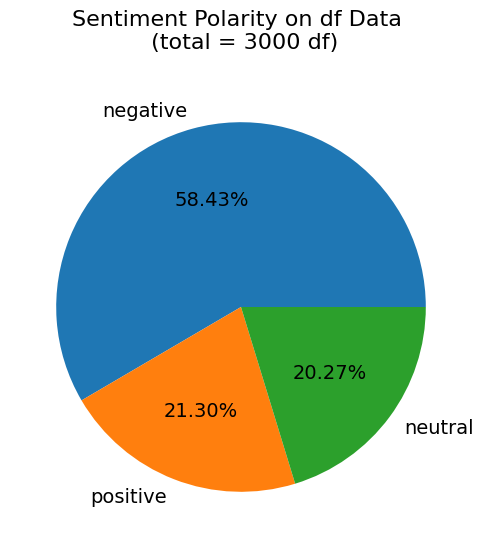

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in df["polarity"].value_counts()]
labels = list(df["polarity"].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(
    x=sizes,
    labels=labels,
    autopct="%1.2f%%",
    textprops={"fontsize": 14},
)
ax.set_title(f"Sentiment Polarity on df Data \n (total = {len(df)} df)", fontsize=16, pad=20)
plt.show()

In [23]:
positive_reviews = df[['text_akhir','polarity']].loc[df['polarity'] == 'positive']
negative_reviews = df[['text_akhir','polarity']].loc[df['polarity'] == 'negative']

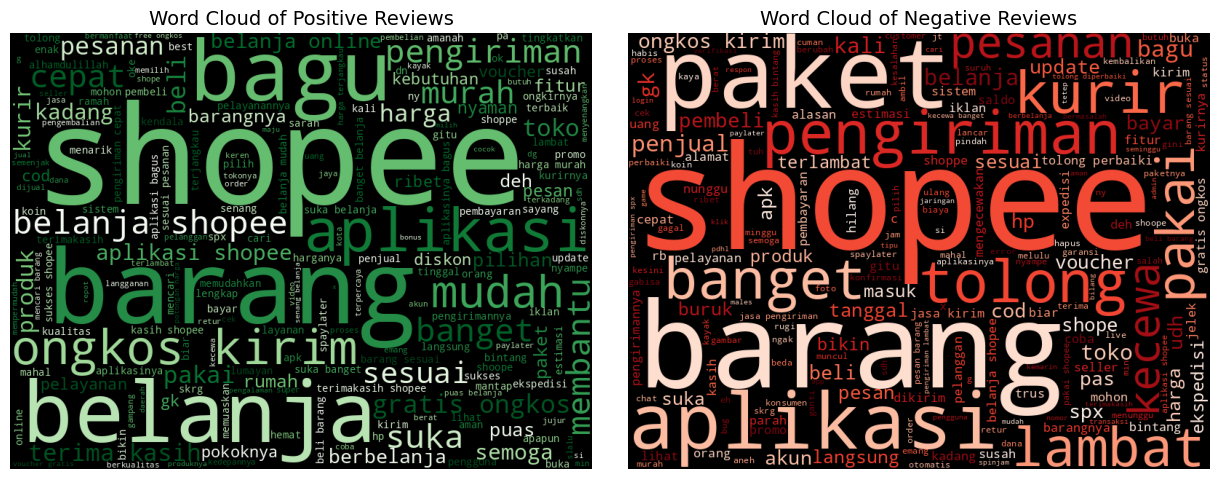

In [24]:
# Visualisasi Word Cloud
fig, ax = plt.subplots(1, 2, figsize=(12, 10))

# Word Cloud pada review positif
list_postive_reviews = ""
for row_word in positive_reviews.iloc[:, 0]:
    list_postive_reviews += " " + (row_word)
wordcloud_positive = WordCloud(
    width=800, height=600, background_color="black", colormap="Greens", min_font_size=10
).generate(list_postive_reviews)
ax[0].set_title(
    "Word Cloud of Positive Reviews",
    fontsize=14,
)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis("off")

# Word Cloud pada review negatif
list_negative_reviews = ""
for row_word in negative_reviews.iloc[:, 0]:
    list_negative_reviews += " " + (row_word)
wordcloud_negative = WordCloud(
    width=800, height=600, background_color="black", colormap="Reds", min_font_size=10
).generate(list_negative_reviews)
ax[1].set_title(
    "Word Cloud of Negative Reviews",
    fontsize=14,
)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis("off")

plt.show()

## 6. Ekstraksi Fitur dan Membangun Model Klasifikasi

### 6.1 Embedding

In [35]:
def makeReviewDict(series):
    # Membuat dictionary berisi kata dan frekuensinya dari suatu pandas Series.
    corpus = []
    words = dict()
    for row in series:
        corpus.append(row)
        texts = row.split()
        for text in texts:
            if text not in words:
                words[text] = 1
            else:
                words[text] += 1
    return corpus, words, len(words)

In [41]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [42]:
corpus = makeReviewDict(df['text_akhir'])[0]
tokenized_corpus = [word_tokenize(sentence.lower()) for sentence in corpus]

In [43]:
# Melatih model Word2Vec
w2v_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

### 6.2 Train Test Split

In [27]:
# Fungsi untuk mendapatkan indeks kata
def get_word_idx(text: str):
    return tokenizer(
        text, padding='max_length',
        truncation=True, max_length=100,
    )['input_ids']

In [28]:
# Fungsi untuk mengubah baris dengan nilai boolean menjadi biner
def convert_to_binary(row):
    result = []
    for value in row.values:
        result.append(1 if value else 0)
    return result

In [29]:
X = np.array(df['text_akhir'].apply(get_word_idx).tolist()).squeeze()
y = np.array(pd.get_dummies(df['polarity']).apply(convert_to_binary, axis=1).tolist())

In [30]:
X.shape, y.shape

((3000, 100), (3000, 3))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 6.3 Pelatihan Model

In [32]:
tf.keras.backend.clear_session()

In [26]:
# Hyperparameter
vocab_size = tokenizer.vocab_size  # Jumlah kata dalam vocab tokenizer
embedding_dim = 100  # Dimensi embedding yang akan digunakan
max_length = makeReviewDict(df['text_akhir'])[1]  # Panjang maksimum input sequence

# Model Klasifikasi
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    # tf.keras.layers.GlobalAveragePooling1D(),  # Meratakan output embedding
    # tf.keras.layers.SpatialDropout1D(0.2), # Dropout khusus data sekuensial seperti teks
    # model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
    tf.keras.layers.LSTM(256, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [34]:
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 228ms/step - accuracy: 0.5398 - loss: 0.5992 - val_accuracy: 0.5967 - val_loss: 0.5674
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 228ms/step - accuracy: 0.5869 - loss: 0.5696 - val_accuracy: 0.5967 - val_loss: 0.5605
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - accuracy: 0.5780 - loss: 0.5738 - val_accuracy: 0.5967 - val_loss: 0.5599
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.6010 - loss: 0.5589 - val_accuracy: 0.5967 - val_loss: 0.5624
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.5895 - loss: 0.5657 - val_accuracy: 0.5967 - val_loss: 0.5614
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.5945 - loss: 0.5621 - val_accuracy: 0.5967 - val_loss: 0.5599
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.5754 - loss: 0.5733 - val_accuracy: 0.5967 - val_loss: 0.5615
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 258ms/step - accuracy: 0.5843 - loss: 0.5683 - val_accu

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 100, 100)              │       3,052,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (32, 100)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,176,279 (35.00 MB)

 Trainable params: 3,058,759 (11.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,117,520 (23.34 MB)

In [ ]:
#Model Testing
print(f'Akurasi test data\t: {model.evaluate(X_test,y_test)[1]*100:.2f} %')
print(f'Akurasi train data\t: {model.evaluate(X_train, y_train)[1]*100:.2f} %')